In [1]:
%config InlineBackend.figure_format = "retina"
import functools
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist

from numpyro import sample, deterministic, plate
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median

NUM_CPUS = int(os.environ.get("NUM_CPUS", os.cpu_count()))
numpyro.set_host_device_count(NUM_CPUS)
numpyro.enable_x64()

# set a random seed
rng_key = jax.random.PRNGKey(42)

# Summary

A series of results show that the covariance function of a stationary process can be expressed as
\begin{align}
k(x_1, x_2) &= \sum_{j=1}^{\infty} S(\sqrt(\lambda_j)) \phi_j(x_1) \phi_j(x_2) \newline
\lambda_j &= \left(\frac{j \pi}{2 L}\right) \newline 
\phi_j(x) &= \sqrt{\frac{1}{L}}\sin\left(\sqrt{\lambda_j}(x + L)\right)
\end{align}

where $\lambda_j, \phi_j(x)$ are the eigenvalues and eigenfunctions of the Laplacian operator in the domain $\left[-L, L\right]$, and $S(w)$ is the spectral density of the covariance matrix.

Key points:
* the eigenfunctions and eigenvalues are not dependent on $k$, only the spectral density $S$ depends on $k$.
* For bounded covariance functions, the spectral density $S(w)\to 0$ as $w\to\infty$. Given that the eigenvalues $\lambda_j$ are monotonically increasing, the sum is dominated by the first few terms.
* This exact result does not hold for periodic covariance functions, but there's an equivalent result that serves the same purpose.

## Example

In [2]:
tspace = np.linspace(0, 3, num=100)

In [3]:
sigma = 1
length = .8

In [4]:
def squared_exponential_kernel(tau, sigma, length):
    # tau is abs(x1 - x2)
    return (sigma ** 2) * jnp.exp(-0.5 * (tau ** 2) / (length ** 2)) 

Text(0, 0.5, '$k(\\tau)$')

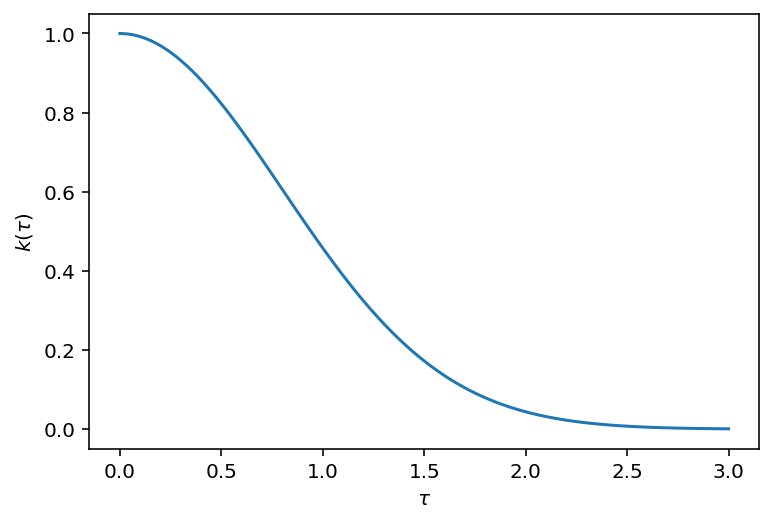

In [5]:
plt.plot(tspace, squared_exponential_kernel(tspace, sigma, length))
plt.xlabel("$\\tau$")
plt.ylabel("$k(\\tau)$")

##### Approximation

In [6]:
# it is convenient to make an approximation that is valid beyond the space we have
# in case we need to do extrapolations. The Hilber space approximation is valid in the
# interval [-L, L]. Note that this requires the x inputs to be centered at 0.
L = 1.5 * max(tspace)

In [7]:
def spectral_density(w, alpha, length):
    c = alpha * jnp.sqrt(2 * jnp.pi) * length
    e = jnp.exp(-0.5 * (length ** 2) * (w ** 2))
    return c * e

def eigenval_j(j, L):
    return ((j * jnp.pi) / (2 * L)) ** 2

def eigenfunc_j(j, x, L):
    val = eigenval_j(j, L)
    return jnp.sqrt(1 / L) * jnp.sin(jnp.sqrt(val) * (x + L))

In [8]:
# Not a vectorized implementaion, but easier to read
def approximate_kernel(t, sigma, length, L, M):
    def term(j):
        S = spectral_density(jnp.sqrt(eigenval_j(j, L)), sigma, length)
        phi1 = eigenfunc_j(j, 0.01, L)
        phi2 = eigenfunc_j(j, 0.01 + t, L)
        return S * phi1 * phi2
    
    return sum(term(j) for j in range(1, M))

Text(0, 0.5, 'K($\\tau$)')

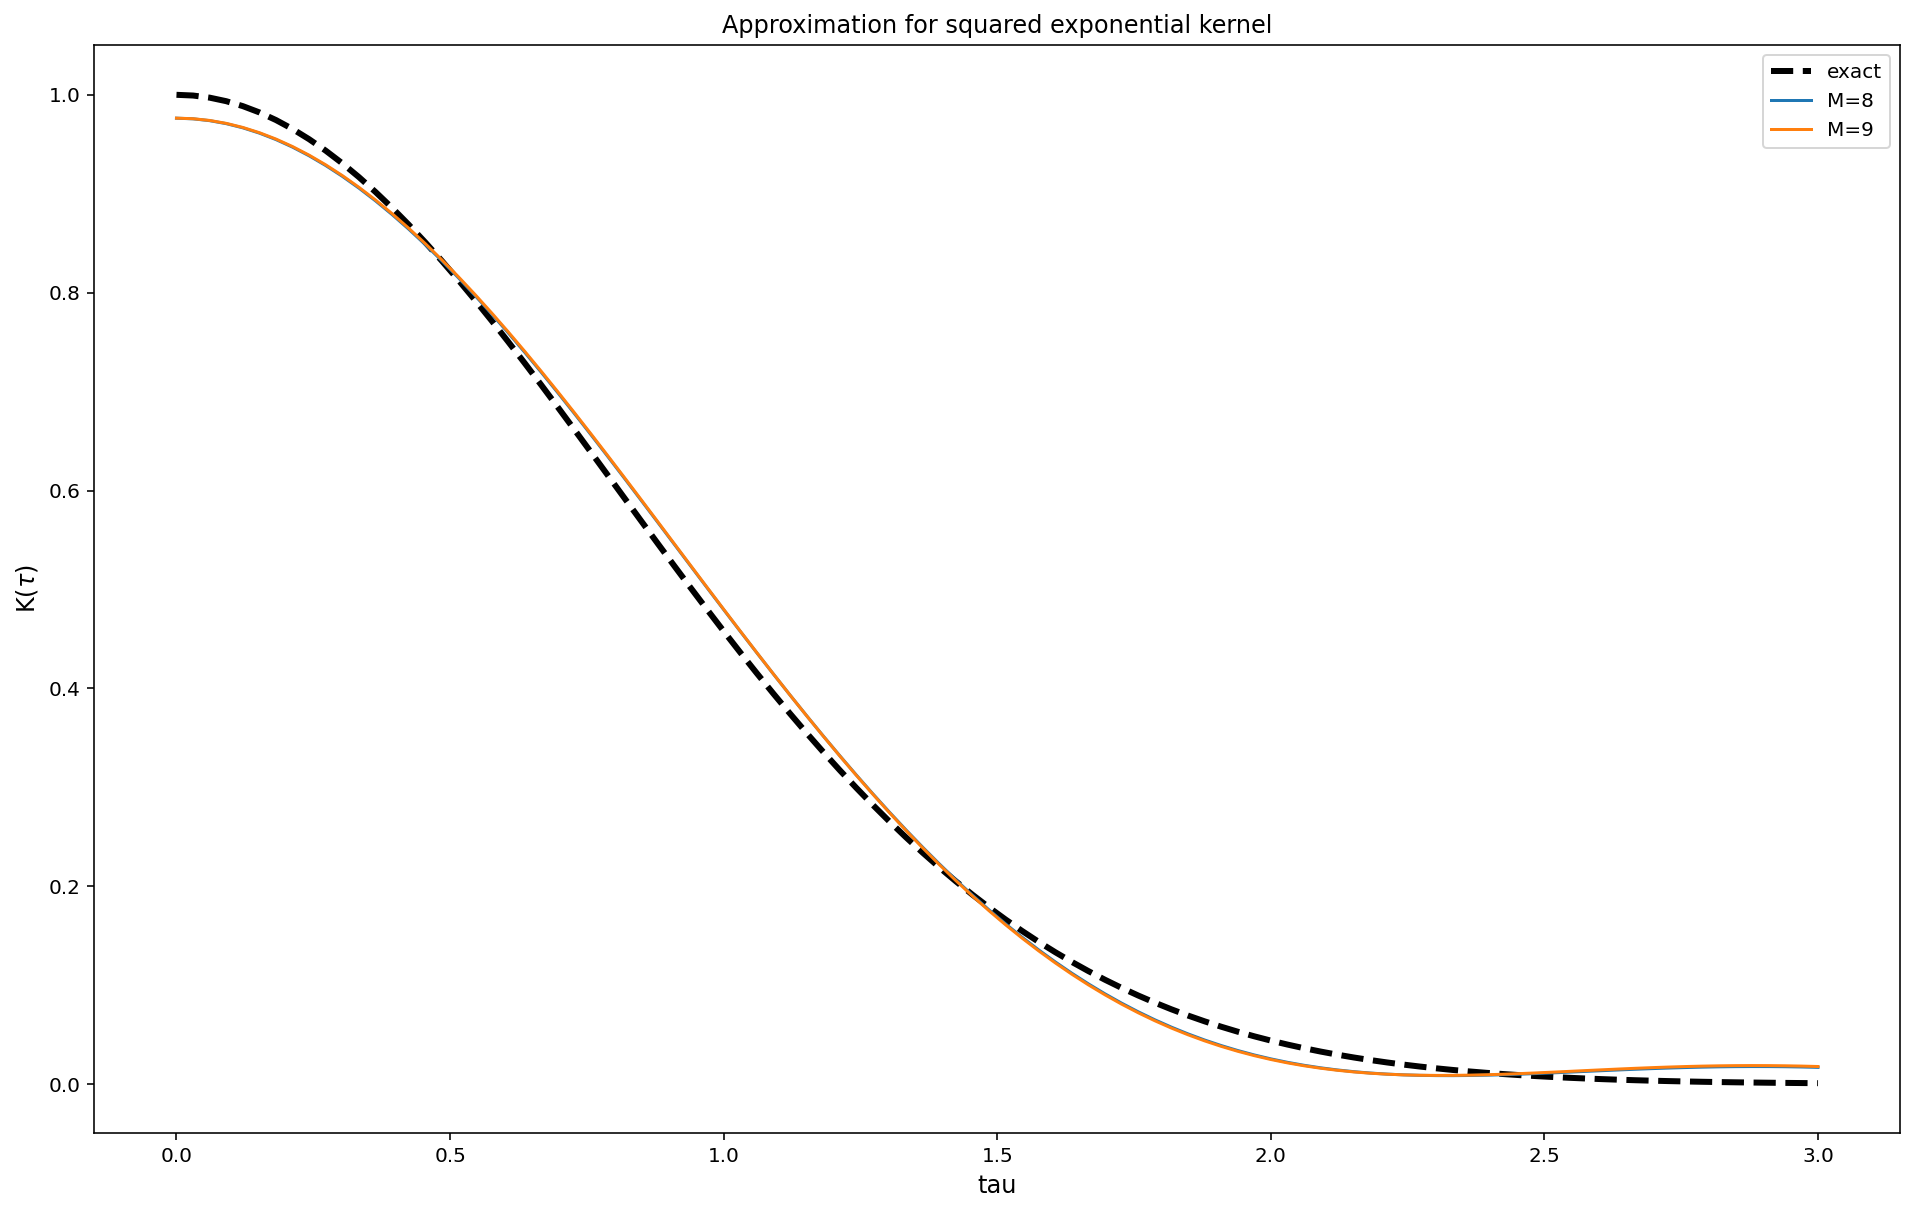

In [9]:
plt.figure(figsize=(10 * 1.618, 10))
plt.plot(tspace, squared_exponential_kernel(tspace, sigma, length), color='k', lw=3, linestyle="--", label='exact')
for m in [8, 9]:
    plt.plot(tspace, approximate_kernel(tspace, sigma, length, L, m), lw=1.5, label=f'M={m}')
plt.legend()
plt.title("Approximation for squared exponential kernel")
plt.xlabel("tau", fontsize=12)
plt.ylabel("K($\\tau$)", fontsize=12)

Text(0, 0.5, 'K($\\tau$)')

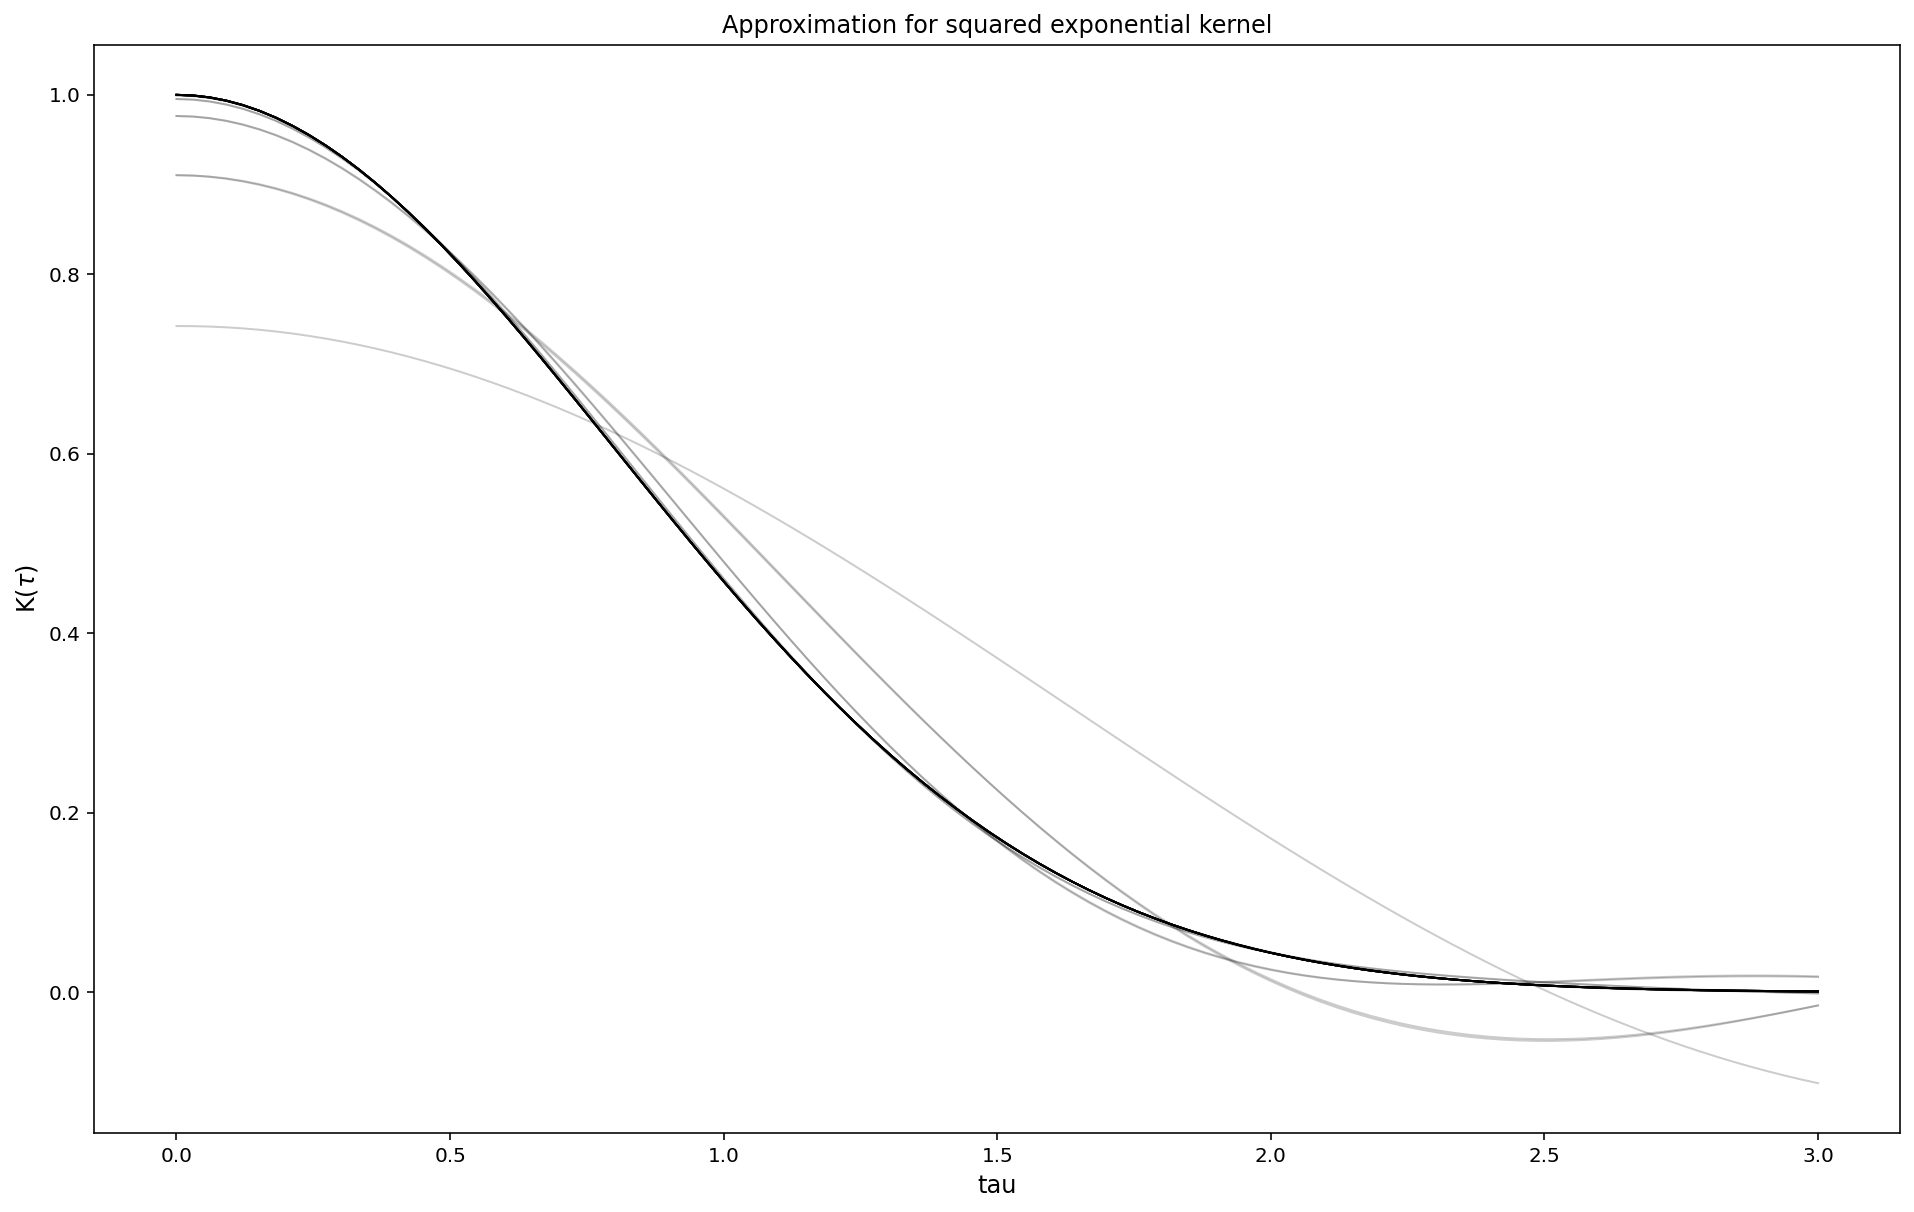

In [10]:
plt.figure(figsize=(10 * 1.618, 10))
for m in range(5, 40):
    plt.plot(tspace, approximate_kernel(tspace, sigma, length, L, m), lw=1, color='k', alpha=0.2)
plt.title("Approximation for squared exponential kernel")
plt.xlabel("tau", fontsize=12)
plt.ylabel("K($\\tau$)", fontsize=12)

# Numpyro implementation

In [11]:
# take from https://gist.github.com/omarfsosa/22e5a7c70cef03ad0c623c8197ee9c5c
def spaghetti_plot(
    x, y, n_samples=20, indices=None, ax=None, plot_kwargs=None
):
    """
    Plots x against a few picked examples of y.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array.
        First axis (0) is the samples axis.
        Second axis (1) are the values for the y axis.
    n_samples: int (default 20)
        How many sampled values to plot. `n_samples` are
        selected uniformly at random.
    indices: 1d array
        Indices of the specific samples that will be selected
        for plotting.
    ax: matplotlib.Axes
        The axes where the figure will be plotted.
    plot_kwargs: dict
        Extra arguments passed to `plt.plot`

    Returns
    -------
    matplotlib.Axes

    """
    has_indices = indices is not None
    has_samples = bool(n_samples)
    if has_indices == has_samples:
        _msg = "Exactly one of `n_samples` or `indices` must be specified"
        raise ValueError(_msg)

    if has_samples:
        indices = np.random.choice(range(y.shape[1]), n_samples)

    ax = ax or plt.gca()
    for idx in indices:
        ax.plot(x, y[idx], **(plot_kwargs or {}))

    return ax


def ribbon_plot(
    x,
    y,
    n_ribbons=10,
    percentile_min=1,
    percentile_max=99,
    ribbon_color="r",
    plot_median=True,
    line_color="k",
    ax=None,
    fill_kwargs=None,
    line_kwargs=None,
):
    """
    Make a ribbon plot that shows the different quantiles of the
    distribution of y against x.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array
    n_ribbons: int (default 10)
        How many quantiles to show
    percentile_min: float, between 0 and 50
        The lowest percentile to be shown
    percentile_max: float between 50 and 100
        The highest percentile to show.
    ribbon_color: str (default 'r')
        Color for the ribbons. Must be a valid expression for
        matplotlib colors.
    plot_median: bool (default True)
        Whether or not to plot a line for the 50% percentile
    line_color: str (default 'k')
        Color to use for the median.
    ax: matplotlib.Axes
        Where to plot the figure.
    fill_kwargs: dict
        Extra arguments passed to `plt.fill_between`.
        Controls the aspect of the ribbons.
    line_kwargs: dict
        Extra arguments to be passed to `plt.plot`.
        Controls the aspect of the median line.

    Returns
    -------
    matplotlib.Axes
    """
    perc1 = np.percentile(
        y,
        np.linspace(percentile_min, 50, num=n_ribbons, endpoint=False),
        axis=0,
    )
    perc2 = np.percentile(
        y, np.linspace(50, percentile_max, num=n_ribbons + 1)[1:], axis=0
    )
    fill_kwargs = fill_kwargs or {}
    line_kwargs = line_kwargs or {}
    alpha = fill_kwargs.pop("alpha", 1 / n_ribbons)
    ax = ax or plt.gca()
    plt.sca(ax)

    # fill ribbons
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(
            x, p1, p2, alpha=alpha, color=ribbon_color, **(fill_kwargs or {})
        )

    if plot_median:
        plot_func = plt.step if fill_kwargs.pop("step", None) else plt.plot
        plot_func(
            x, np.median(y, axis=0), color=line_color, **(line_kwargs or {})
        )

    return plt.gca()

### Centered implementations

In [12]:
# --- exact gaussian process
def exact_gp(x, sigma, length, y=None):
    dx = x[:, None] - x
    cov = squared_exponential_kernel(dx, sigma, length)
    jit = 1e-8 * jnp.eye(cov.shape[0])
    f = sample("f", dist.MultivariateNormal(covariance_matrix=cov + jit))

    
# --- approximation
# --- Note: We do some work to vectorize the previous functions
def diag_spectral_density(alpha, length, L, M):
    """spd for squared exponential kernel"""
    sqrt_eigenvalues = jnp.arange(1, 1 + M) * jnp.pi / 2 / L
    return spectral_density(sqrt_eigenvalues, alpha, length)


def eigenfunctions(x, L, M):
    """
    The first `M` eigenfunctions of the laplacian operator in `[-L, L]`
    evaluated at `x`. These are used for the approximation of the
    squared exponential kernel.
    """
    m1 = (jnp.pi / (2 * L)) * jnp.tile(L + x[:, None], M)
    m2 = jnp.diag(jnp.linspace(1, M, num=M))
    num = jnp.sin(m1 @ m2)
    den = jnp.sqrt(L)
    return num / den

def approx_gp(x, sigma, length, L, M, y=None):
    phi = eigenfunctions(x, L, M)
    spd = diag_spectral_density(sigma, length, L, M)
    cov = phi @ jnp.diag(spd) @ phi.T
    jit = 1e-8 * jnp.eye(cov.shape[0])
    f = sample("f", dist.MultivariateNormal(covariance_matrix=cov + jit))

In [13]:
x = jnp.linspace(-3, 3, num=300)

In [14]:
exact_prior = Predictive(exact_gp, num_samples=1000)
rng_key, _ = jax.random.split(rng_key)
exact_samples = exact_prior(rng_key, x, sigma, length)

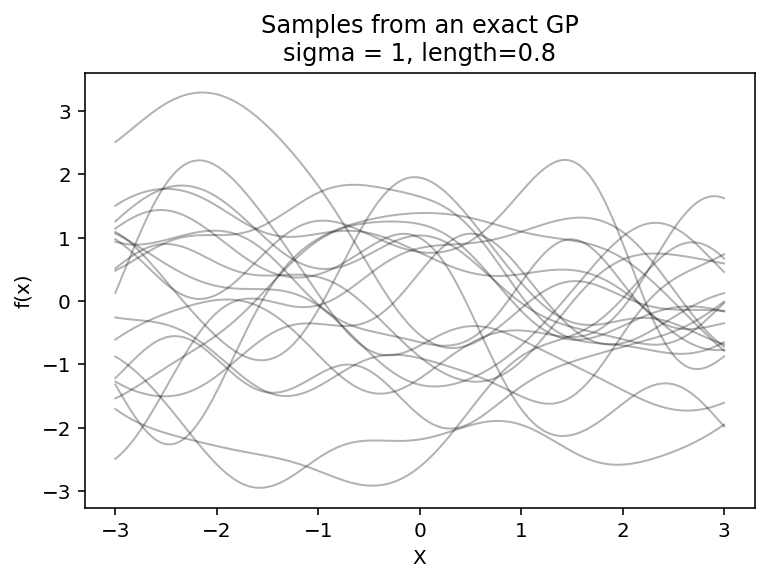

In [15]:
spaghetti_plot(x, exact_samples['f'], plot_kwargs=dict(color='k', lw=1, alpha=0.3))
plt.title(f"Samples from an exact GP\nsigma = {sigma}, length={length}")
plt.xlabel("X")
plt.ylabel("f(x)")
plt.show()

In [16]:
# number of basis functions for the approximation
M = 10

In [17]:
approx_prior = Predictive(approx_gp, num_samples=1000)
rng_key, _ = jax.random.split(rng_key)
approx_samples = approx_prior(rng_key, x, sigma, length, L=L, M=M)

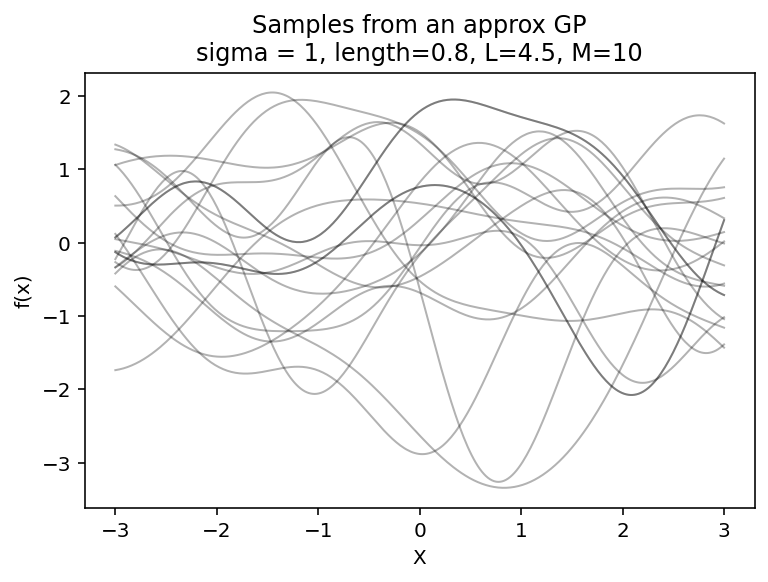

In [18]:
spaghetti_plot(x, approx_samples['f'], plot_kwargs=dict(color='k', lw=1, alpha=0.3))
plt.title(f"Samples from an approx GP\nsigma = {sigma}, length={length}, L={L}, M={M}")
plt.xlabel("X")
plt.ylabel("f(x)")
plt.show()

##### Take a sample to use it as synthetic data

In [19]:
mu = jnp.exp(exact_samples["f"][0])
y = np.random.poisson(mu)

Text(0.5, 1.0, 'Synthetic poisson data with\n log mean given by a GP')

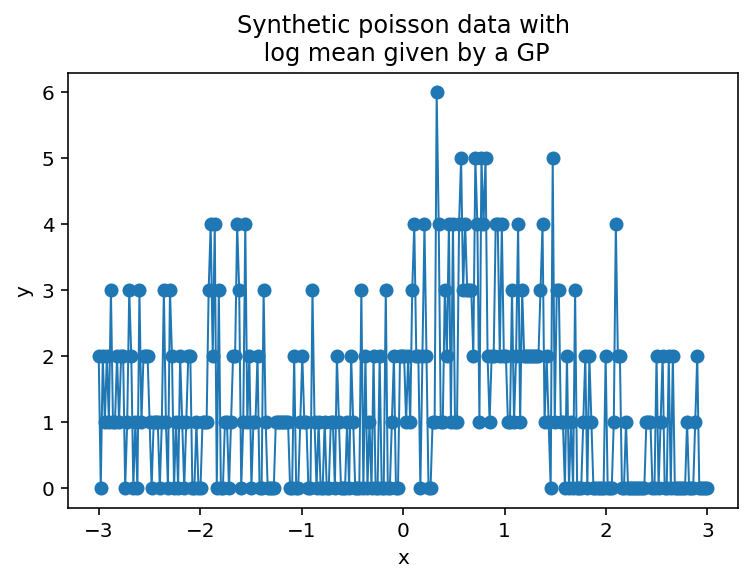

In [20]:
plt.plot(x, y, marker='o', lw=1);
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic poisson data with\n log mean given by a GP")

## Fitting

The centered GPs are not recommended for fitting data. It's best to use a non-centered parametrization.

In [21]:
def exact_gp_ncp(x, sigma, length, y=None):
    dx = x[:, None] - x
    jit = 1e-8 * jnp.eye(x.shape[0])
    cov = squared_exponential_kernel(dx, sigma, length) + jit
    L_cov = jnp.linalg.cholesky(cov)

    with numpyro.plate("n_obs", x.shape[0]):
        f_tilde = numpyro.sample("f_tilde", dist.Normal(0, 1))
        f = numpyro.deterministic("f", L_cov @ f_tilde)
        numpyro.sample("y", dist.Poisson(jnp.exp(f)), obs=y)

In [22]:
exact_mcmc = MCMC(NUTS(exact_gp_ncp), num_warmup=2000, num_samples=2000, num_chains=4)
rng_key, _ = jax.random.split(rng_key)

In [23]:
exact_mcmc.run(rng_key, x, sigma, length, y=jnp.array(y))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

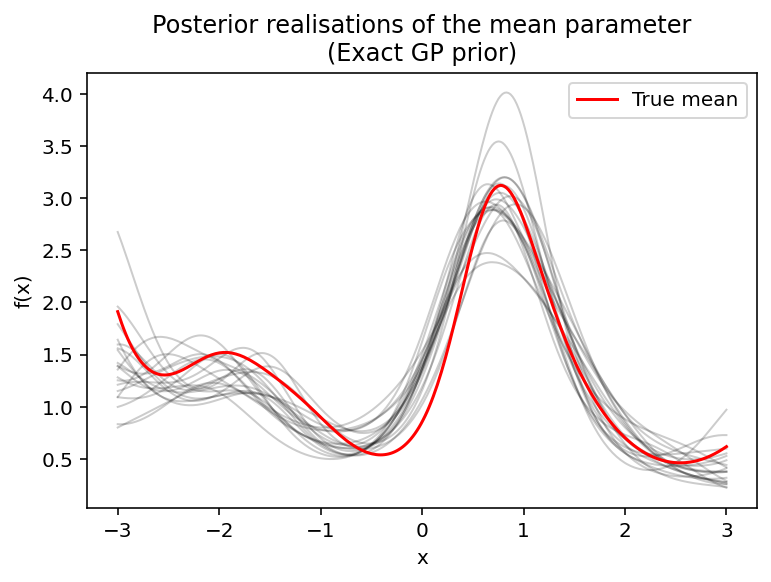

In [24]:
spaghetti_plot(x, jnp.exp(exact_mcmc.get_samples()["f"]), plot_kwargs=dict(color='k', lw=1, alpha=0.2))
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Exact GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend();

In [25]:
def approx_gp_ncp(x, sigma, length, L, M, y=None):
    phi = eigenfunctions(x, L, M)
    spd = jnp.sqrt(diag_spectral_density(sigma, length, L, M))
    with plate("basis", M):
        β = sample("β", dist.Normal(0, 1))
    
    f = deterministic("f", phi @ (spd * β))

    with plate("n_obs", x.shape[0]):
        numpyro.sample("y", dist.Poisson(jnp.exp(f)), obs=y)

In [26]:
approx_mcmc = MCMC(NUTS(approx_gp_ncp), num_warmup=2000, num_samples=2000, num_chains=4)
rng_key, _ = jax.random.split(rng_key)

In [27]:
approx_mcmc.run(rng_key, x, sigma, length, L=L, M=M, y=jnp.array(y))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

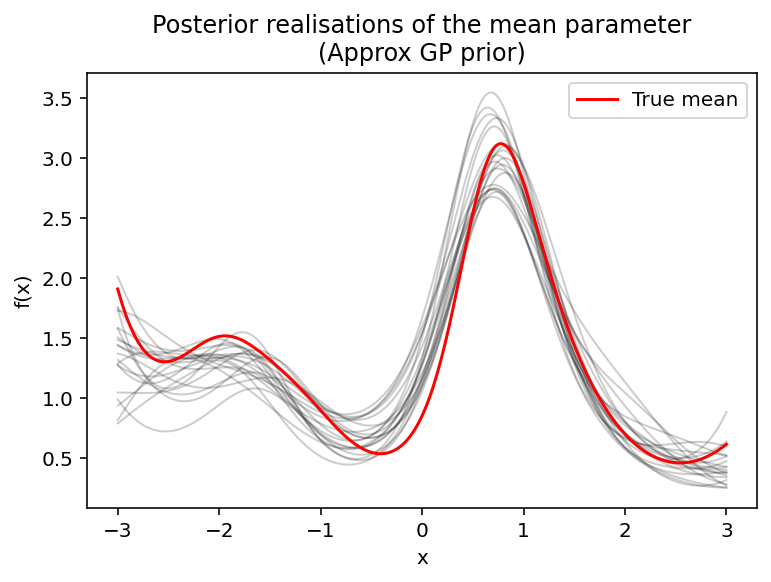

In [28]:
spaghetti_plot(x, jnp.exp(approx_mcmc.get_samples()["f"]), plot_kwargs=dict(color='k', lw=1, alpha=0.2))
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Approx GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend();

## Predicting in new x

In [29]:
x_new = jnp.linspace(3, 4)[1:]
x_all = jnp.concatenate((x, x_new))

#### Prediciting with exact gp is annoying

In [30]:
from tqdm.notebook import tqdm

In [31]:
def predict(x, f, x_pred, sigma, length):
    """
    Note: this implementation assumes that
    the GP has mean 0.
    """
    dpred = x_pred[:, None] - x_pred
    dmix = x[:, None] - x_pred
    dobs = x[:, None] - x
    
    # k_pred = squared_exponential_kernel(dpred, sigma, length)
    k_mix = squared_exponential_kernel(dmix, sigma, length)
    k_obs = squared_exponential_kernel(dobs, sigma, length)
    jit = 1e-6 * jnp.eye(x.shape[0])
    k_obs_inv = jnp.linalg.inv(k_obs + jit)
    
    #  cov = k_pred - k_mix.T @ k_obs_inv @ k_mix
    mean = k_mix.T @ k_obs_inv @ f
    # f_pred ~ multinormal(mean, cov)
    return mean

In [32]:
f_samples = exact_mcmc.get_samples()["f"]
f_preds = []
for f in tqdm(f_samples[::20]):
    pred = predict(x, f, x_new, sigma, length)
    f_preds.append(pred)

  0%|          | 0/400 [00:00<?, ?it/s]

In [33]:
f_preds = jnp.array(f_preds)

In [34]:
f_all_exact = jnp.concatenate((f_samples[::20], f_preds), axis=1)

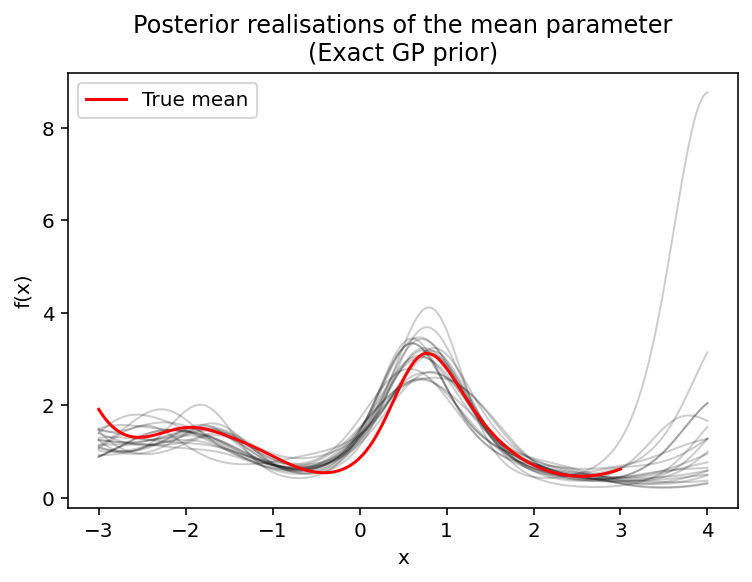

In [35]:
spaghetti_plot(x_all, jnp.exp(f_all_exact), plot_kwargs=dict(color='k', alpha=0.2, lw=1))
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Exact GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend();

#### Predicting with approx gp is easy

In [36]:
posterior_predictive = Predictive(approx_gp_ncp, posterior_samples=approx_mcmc.get_samples())
rng_key, _ = jax.random.split(rng_key)

In [37]:
f_all_approx = posterior_predictive(rng_key, x_all, sigma, length, L, M)["f"]

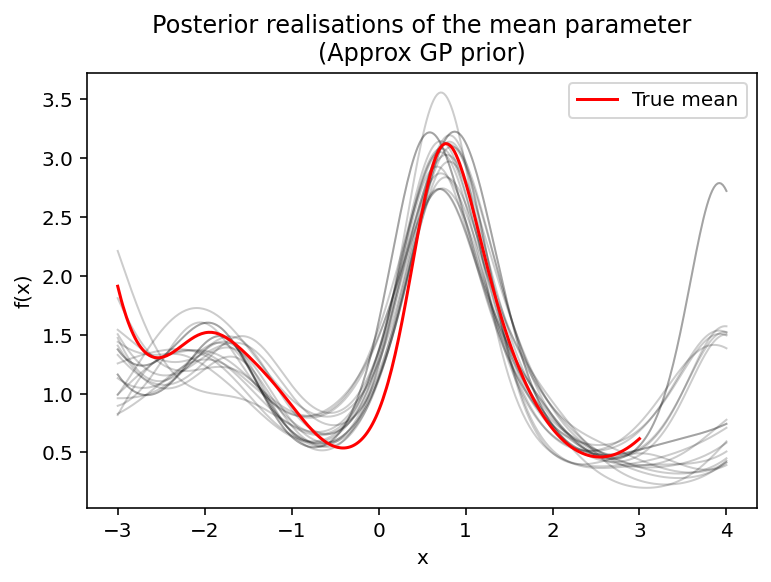

In [38]:
spaghetti_plot(x_all, jnp.exp(f_all_approx), plot_kwargs=dict(color='k', lw=1, alpha=0.2))
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Approx GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend()

##### One can also use the previous method:

In [39]:
f_samples_approx = approx_mcmc.get_samples()["f"]
f_preds_approx = []
for f in tqdm(f_samples_approx[::20]):
    pred = predict(x, f, x_new, sigma, length)
    f_preds_approx.append(pred)

  0%|          | 0/400 [00:00<?, ?it/s]

In [40]:
f_preds_approx = jnp.array(f_preds_approx)
f_all_approx2 = jnp.concatenate((f_samples_approx[::20], f_preds_approx), axis=1)

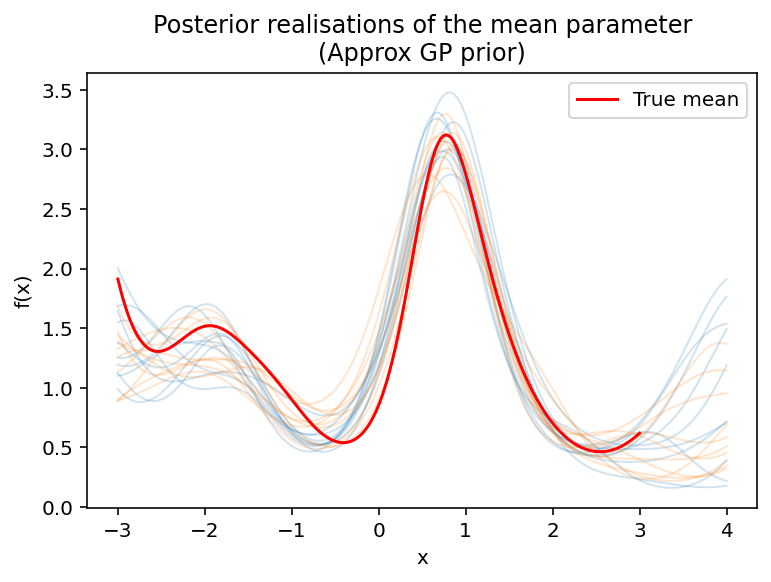

In [41]:
spaghetti_plot(x_all, jnp.exp(f_all_exact), plot_kwargs=dict(color='C0', lw=1, alpha=0.2), indices=range(10), n_samples=None)
spaghetti_plot(x_all, jnp.exp(f_all_approx), plot_kwargs=dict(color='C1', lw=1, alpha=0.2), indices=range(10), n_samples=None)
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Approx GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend();

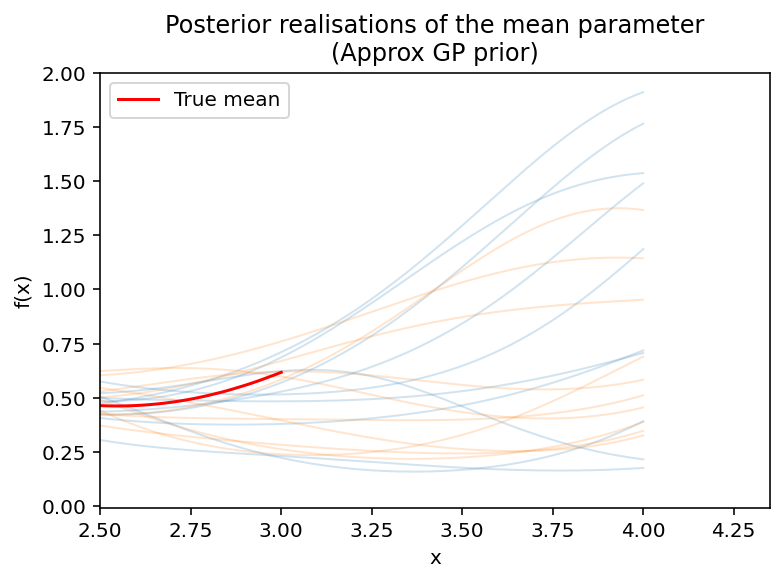

In [42]:
spaghetti_plot(x_all, jnp.exp(f_all_exact), plot_kwargs=dict(color='C0', lw=1, alpha=0.2), indices=range(10), n_samples=None)
spaghetti_plot(x_all, jnp.exp(f_all_approx), plot_kwargs=dict(color='C1', lw=1, alpha=0.2), indices=range(10), n_samples=None)
plt.plot(x, mu, color='r', label='True mean')
plt.title("Posterior realisations of the mean parameter\n(Approx GP prior)")
plt.xlabel('x')
plt.ylabel("f(x)")
plt.legend()
plt.xlim(2.5, None)
plt.ylim(None, 2);

##### Posterior realizations of the data

In [43]:
y_all_exact = np.random.poisson(jnp.exp(f_all_exact))
y_all_approx = np.random.poisson(jnp.exp(f_all_approx))

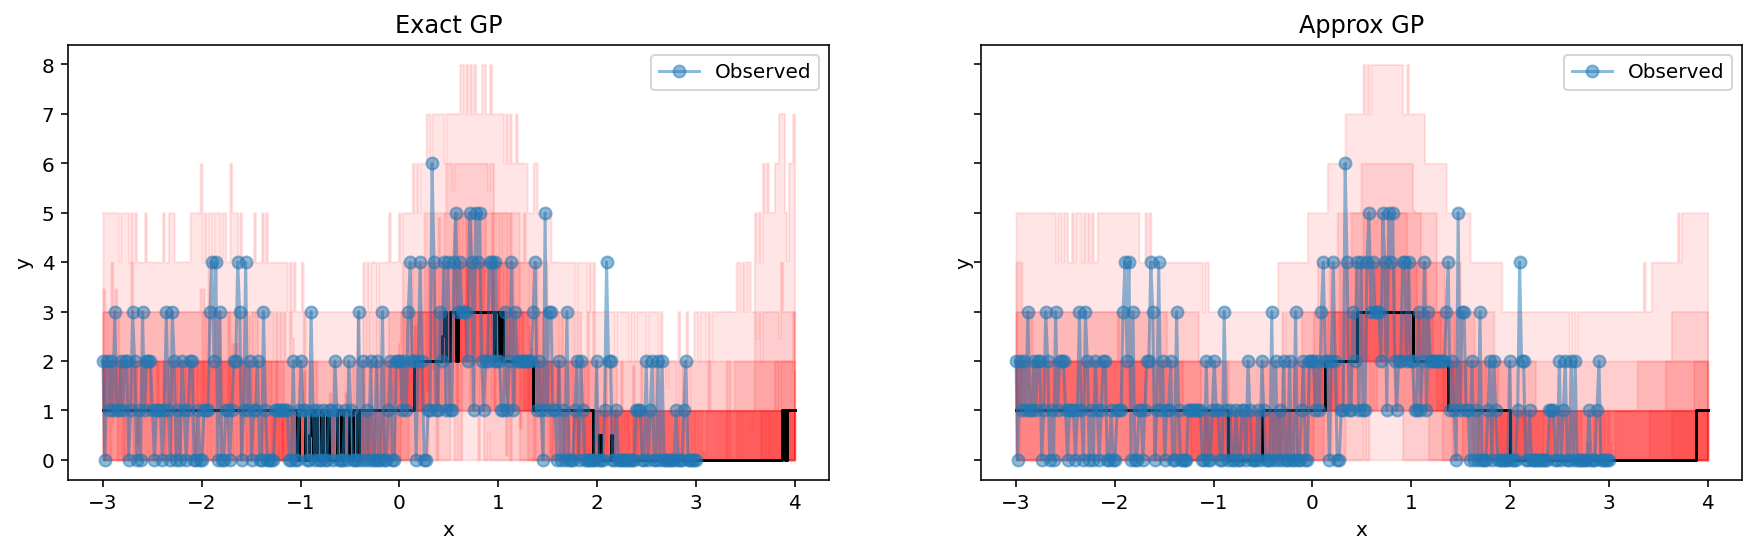

In [44]:
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
ribbon_plot(x_all, y_all_exact, ax=axes[0], fill_kwargs={"step": "pre"})
axes[0].set_title("Exact GP")
ribbon_plot(x_all, y_all_approx, ax=axes[1], fill_kwargs={"step": "pre"})
axes[1].set_title("Approx GP")

for ax in axes:
    ax.plot(x, y, marker='o', alpha=0.5, label='Observed')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
plt.show()